# Model Performance


## Prerequisites
Install python packages

In [6]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics requests

## Import required python packages

In [7]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import seaborn as sns
from tqdm.auto import tqdm
sns.set_theme(style="whitegrid")
%matplotlib inline

In [8]:
def download_inference(
    extract_dir="qa-results", record="12734644", filename="breast-mr.zip"
):
    url = f"https://zenodo.org/record/{record}/files/{filename}"
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)

qa_dir = Path("qa-results")
if not qa_dir.exists() or not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference(qa_dir)

In [9]:
def load_dcm_seg(seg_path: Path, label=1):
    reader = pydicom_seg.SegmentReader()
    dcm = pydicom.dcmread(str(seg_path))
    seg = reader.read(dcm)
    if label in seg._segment_data:
        result = sitk.GetImageFromArray(seg._segment_data[label])
    else:
        # Create a zero-valued image with the same dimensions, origin, spacing, and direction
        zero_array = np.zeros_like(seg._segment_data[1])
        result = sitk.GetImageFromArray(zero_array)
    result = sitk.Cast(result, sitk.sitkUInt8)
    result.SetOrigin(seg.origin)
    result.SetSpacing(seg.spacing)
    result.SetDirection(seg.direction.flatten())
    result = sitk.Cast(result, sitk.sitkUInt8)
    return result


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    if label==1:
        img = sitk.Cast(img >= label, sitk.sitkUInt8)
    else:
        img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, fname, label_value=1, version="aimiv2", label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)
    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),
        "SeriesUID": fname,  # from medical segmentation decathlon
        "label": label_value,
        "version": version,
    }

    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np


# Load the CSV file
df = pd.read_csv(Path("qa-results/qa-results.csv").resolve())

# Paths for aimiv1, aimiv2, and qa
aimiv1_path = Path("qa-results/aimiv1-ai-segmentations").resolve()
aimiv2_path = Path("qa-results/ai-segmentations-dcm").resolve()
qa_path = Path("qa-results/qa-segmentations-dcm").resolve()

# Initialize lists for metrics
aimiv1_metrics = []
aimiv2_metrics = []

# Iterate over files in qa_path
for file in tqdm(
    qa_path.glob("*dcm"), desc="Calcualting metrics"):
    fname = Path(file.stem).stem.split("qa-")[-1]

    # File paths for aimiv1 and aimiv2 versions
    aimiv1_fname = aimiv1_path / f"aimiv1-{fname}.nii.gz"
    aimiv2_fname = aimiv2_path / f"ai-{fname}.seg.dcm"
    qa_seg_file = qa_path / f"qa-{fname}.seg.dcm"

    # Check if aimiv1 and qa files exist before proceeding
    if aimiv1_path.exists() and qa_seg_file.exists():
        # Calculate aimiv1 metrics if aimiv1 path is provided
        aimiv1_metrics.append(
            calc_metrics_for_label(
                aimiv1_fname, qa_seg_file, fname, version="aimiv1", label_value=2
            )
        )
        aimiv1_metrics.append(
            calc_metrics_for_label(
                aimiv1_fname, qa_seg_file, fname, version="aimiv1", label_value=1
            )
        )

    # Calculate aimiv2 metrics in any case
    aimiv2_metrics.append(
        calc_metrics_for_label(
            aimiv2_fname, qa_seg_file, fname, label_value=3, version="aimiv2"
        )
    )
    aimiv2_metrics.append(
        calc_metrics_for_label(aimiv2_fname, qa_seg_file, fname, label_value=2, version="aimiv2")
    )
    aimiv2_metrics.append(
        calc_metrics_for_label(
            aimiv2_fname, qa_seg_file, fname, label_value=1, version="aimiv2"
        )
    )

# Create DataFrames for aimiv1 and aimiv2 metrics
aimiv2_df = pd.DataFrame(aimiv2_metrics)
# aimiv2_df = aimiv2_df.add_prefix("aimiv2_")
# aimiv2_df.rename(columns={"aimiv2_SeriesUID": "SeriesUID"}, inplace=True)

if aimiv1_metrics:
    aimiv1_df = pd.DataFrame(aimiv1_metrics)
    # aimiv1_df = aimiv1_df.add_prefix("aimiv1_")
    # aimiv1_df.rename(columns={"aimiv1_SeriesUID": "SeriesUID"}, inplace=True)
else:
    aimiv1_df = pd.DataFrame(columns=aimiv2_df.columns)

# Merge DataFrames on 'SeriesUID'
combined_df = pd.concat([aimiv2_df, aimiv1_df])

# Replace infinite values with NaN and drop NaN values
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

# # Concatenate aimiv1 and aimiv2 DataFrames for aggregation
# combined_df = pd.concat(
#     [combined_df[aimiv1_df.columns], combined_df[aimiv2_df.columns]]
# )

# Group by 'label' and 'version' and aggregate metrics
aggregated_df = (
    combined_df.groupby(["label", "version"])
    .agg(
        {
            "dice": ["mean", "std"],
            "hausdorff_distance_95": ["mean", "std"],
            "mean_surface_distance": ["mean", "std"],
            "mean_surface_distance_tol_7": ["mean", "std"],
        }
    )
    .round(2)
)

aggregated_df

Calcualting metrics: 0it [00:00, ?it/s]

dice       hausdorff_distance_95        mean_surface_distance  \
               mean   std                  mean    std                  mean   
label version                                                                  
1     aimiv2   0.99  0.04                  4.05   6.58                  0.35   
2     aimiv2   0.80  0.29                  8.75  12.92                  1.82   
3     aimiv2   0.57  0.36                 41.44  51.78                  9.36   

                     mean_surface_distance_tol_7        
                 std                        mean   std  
label version                                           
1     aimiv2    0.53                        0.98  0.04  
2     aimiv2    4.17                        0.88  0.23  
3     aimiv2   13.79                        0.71  0.27

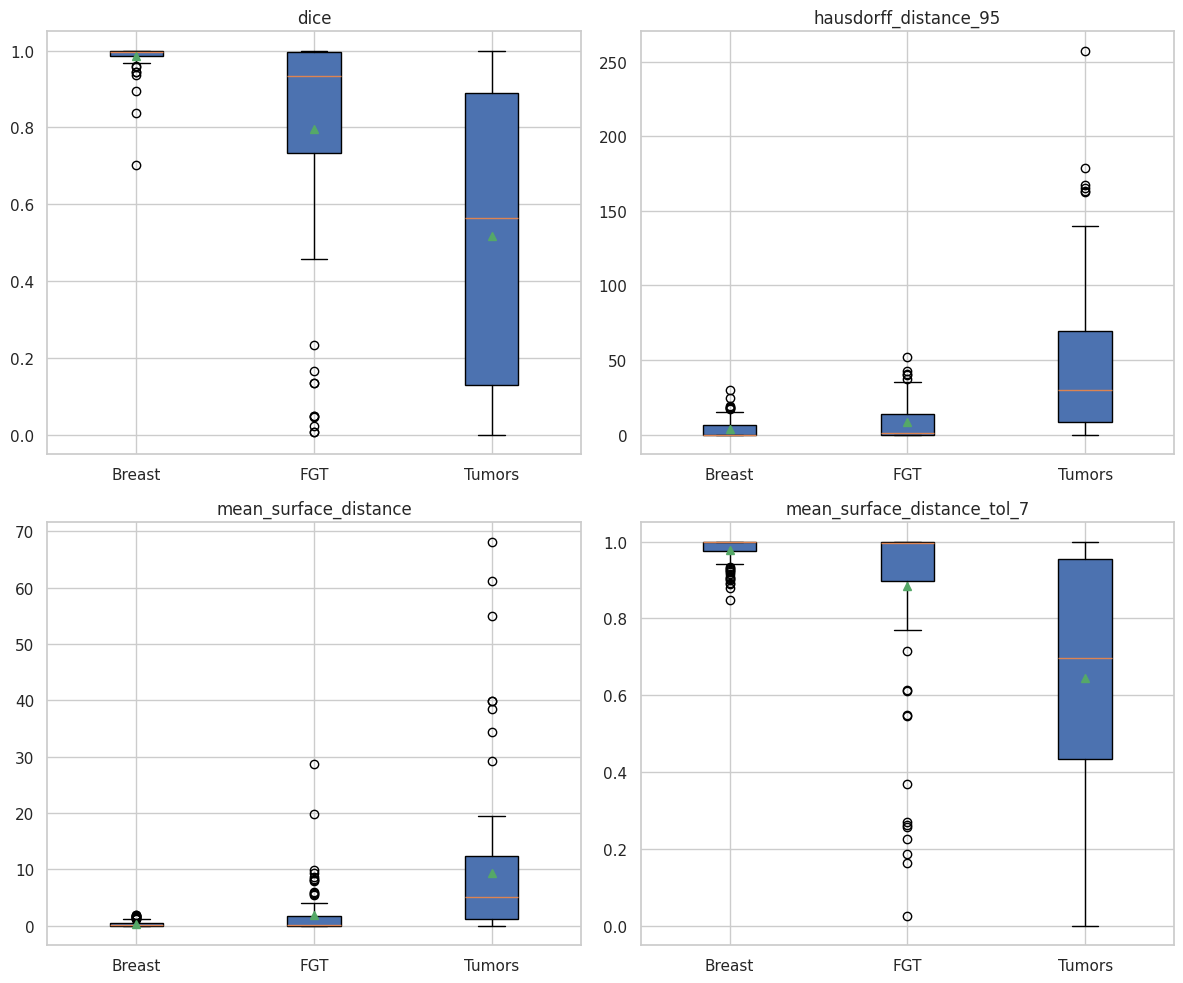

In [17]:
# Separate data for label1 (lung) and label2 (lesion) for aimiv2
aimiv2_label1_df = aimiv2_df[aimiv2_df["label"] == 1]
aimiv2_label2_df = aimiv2_df[aimiv2_df["label"] == 2]
aimiv2_label3_df = aimiv2_df[aimiv2_df["label"] == 3]

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# List of metrics to plot
metrics = [
    "dice",
    "hausdorff_distance_95",
    "mean_surface_distance",
    "mean_surface_distance_tol_7",
]

# Plot each metric
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Extract data for current metric
    label1_data = aimiv2_label1_df[metric]
    label2_data = aimiv2_label2_df[metric]
    label3_data = aimiv2_label3_df[metric]

    # Check if label2_data has values and is not empty
    if not label2_data.empty and not label1_data.empty:
        # Convert data to numeric if necessary
        label1_data = pd.to_numeric(label1_data, errors="coerce")
        label2_data = pd.to_numeric(label2_data, errors="coerce")
        label3_data = pd.to_numeric(label3_data, errors="coerce")

        # Drop NaN values if any (optional)
        label1_data = label1_data.dropna()
        label2_data = label2_data.dropna()
        label3_data = label3_data.dropna()

        # Check if after dropping NaN, there's still data
        if not label1_data.empty and not label2_data.empty and not label3_data.empty:
            # Create boxplots side by side
            ax.boxplot([label1_data, label2_data, label3_data], patch_artist=True, showmeans=True)
            ax.set_title(f"{metric.split('aimiv2_')[-1]}")
            ax.set_xticklabels(
                ["Breast", "FGT", "Tumors"]
            )  # Update x-axis labels to "Lesions"
        else:
            # Handle case where data might be dropped to empty
            print(f"No valid data available for {metric} after cleaning.")
    else:
        # If label2_data is empty, handle accordingly (e.g., print a message)
        print(f"No data available for {metric} in label2 (Lesions).")

# Adjust layout
plt.tight_layout()
plt.show()